In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

df.set_index('date', inplace=True)
df.head()

date      time cash_type          coffee_name  money
0 2023-03-01  08:04:19      card                Latte     75
1 2023-03-01  08:08:54      cash  Americano with Milk     70
2 2023-03-01  08:09:03      card           Cappuccino     75
3 2023-03-01  08:10:26      cash           Cappuccino     75
4 2023-03-01  08:15:37      cash           Cappuccino     75

time cash_type          coffee_name  money
date                                                      
2023-03-01  08:04:19      card                Latte     75
2023-03-01  08:08:54      cash  Americano with Milk     70
2023-03-01  08:09:03      card           Cappuccino     75
2023-03-01  08:10:26      cash           Cappuccino     75
2023-03-01  08:15:37      cash           Cappuccino     75

In [22]:
daily_sales_by_item = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
display(daily_sales_by_item.head())
coffee_items = daily_sales_by_item['coffee_name'].unique()
print("เครื่องดื่มทั้งหมด:", coffee_items)

date          coffee_name  money
0 2023-03-01            Americano   1235
1 2023-03-01  Americano with Milk   1890
2 2023-03-01           Cappuccino   1800
3 2023-03-01                Cocoa    350
4 2023-03-01              Cortado    980

เครื่องดื่มทั้งหมด: ['Americano' 'Americano with Milk' 'Cappuccino' 'Cocoa' 'Cortado'
 'Espresso' 'Hot Chocolate' 'Latte']


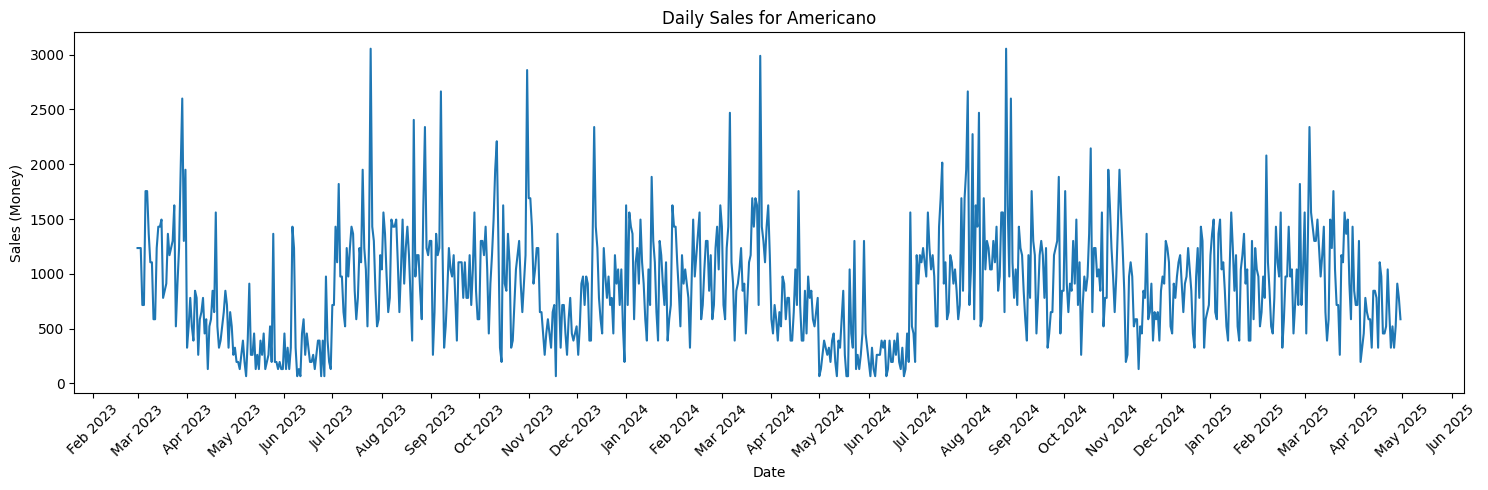

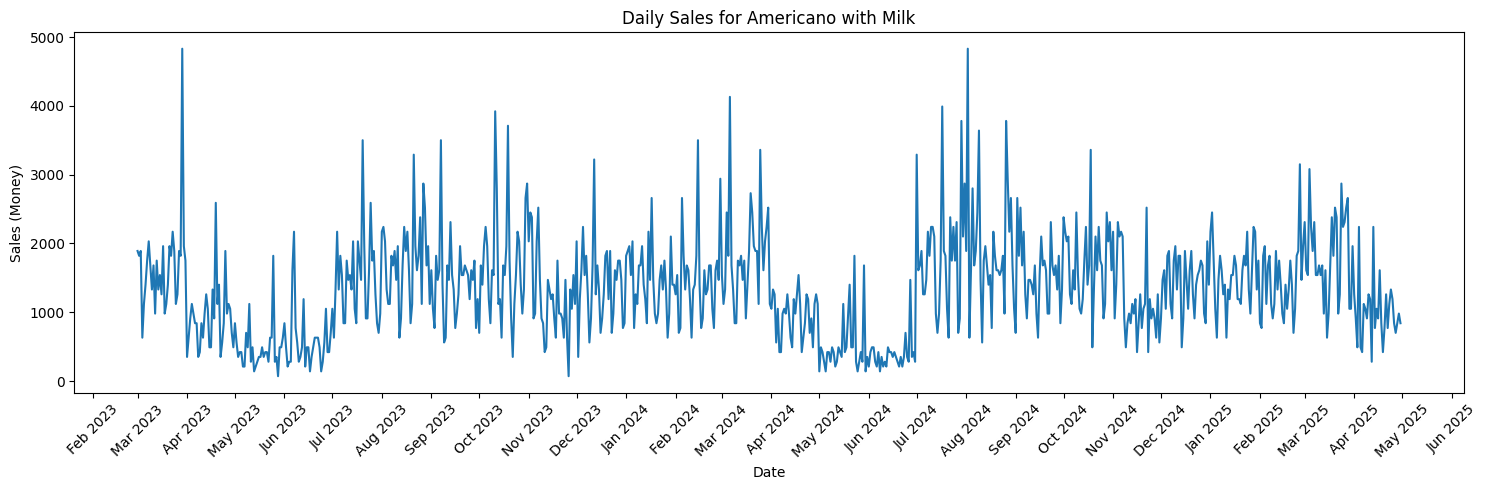

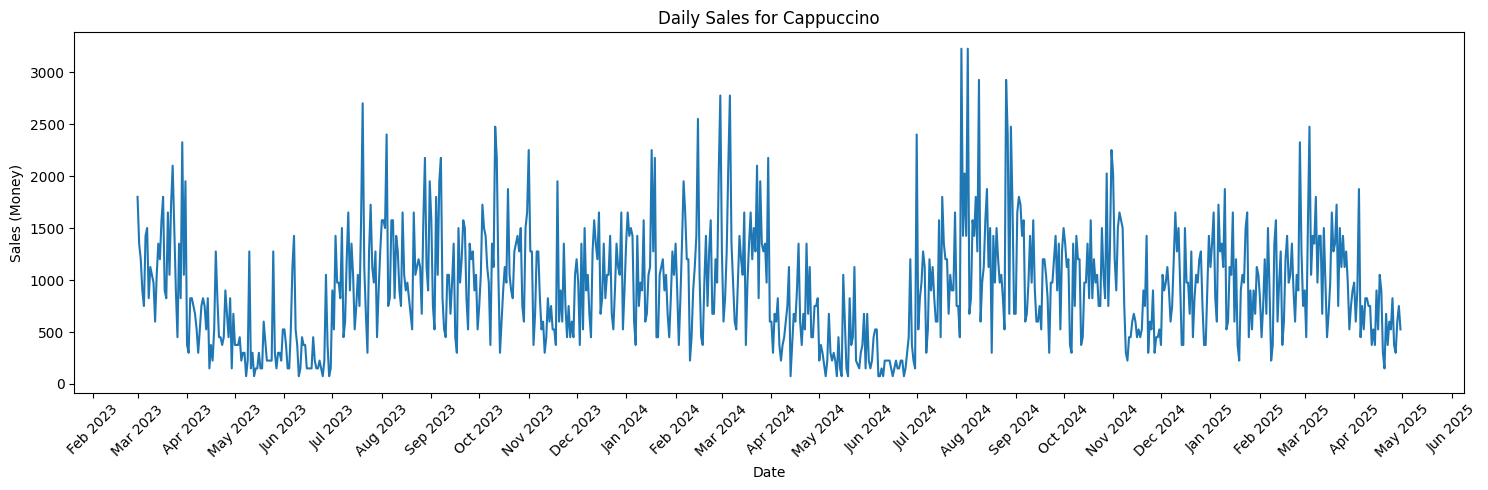

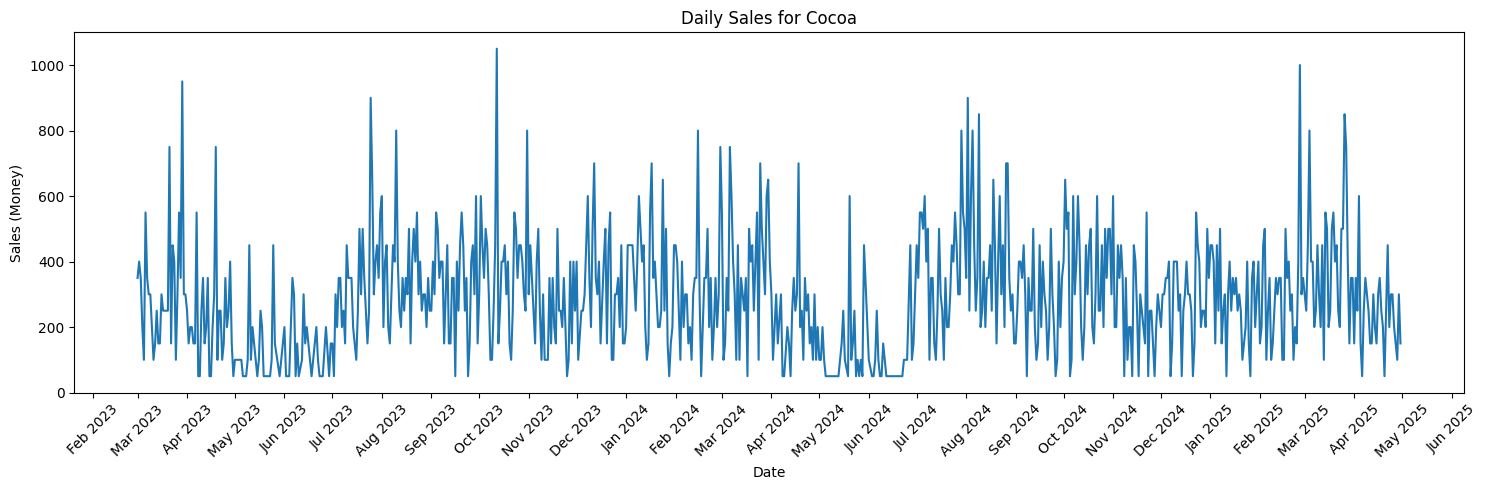

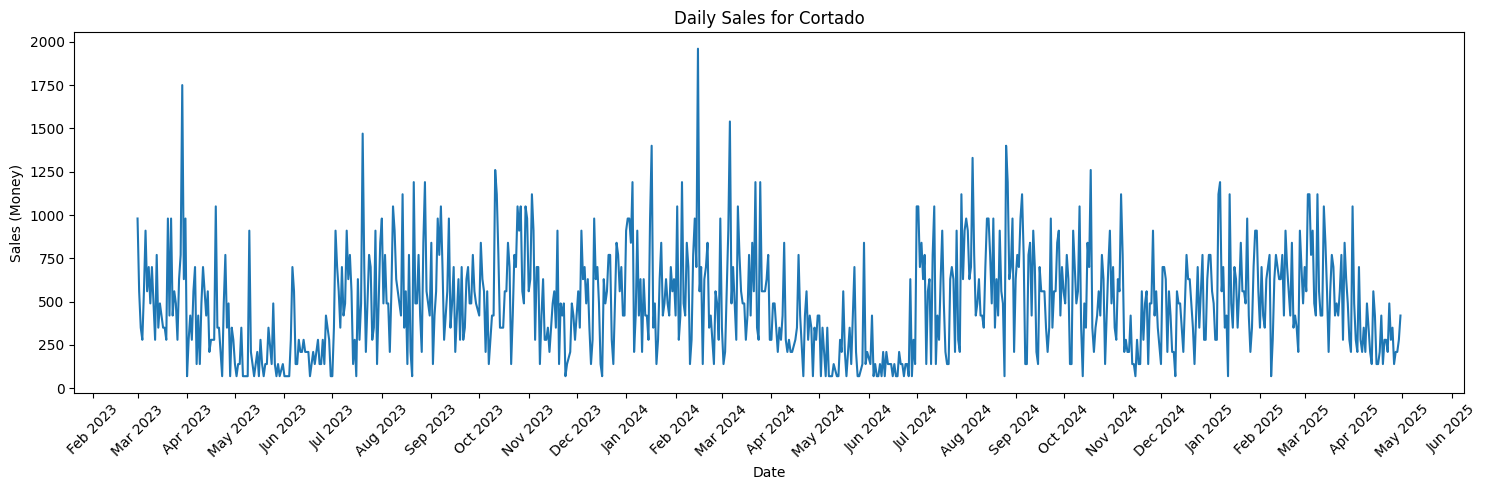

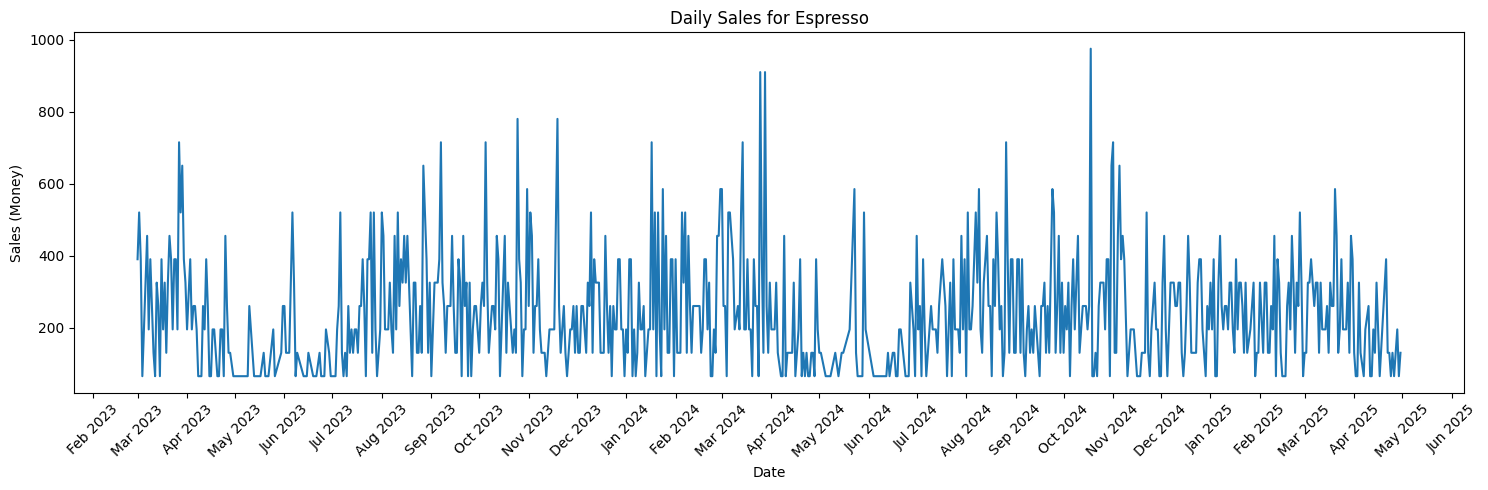

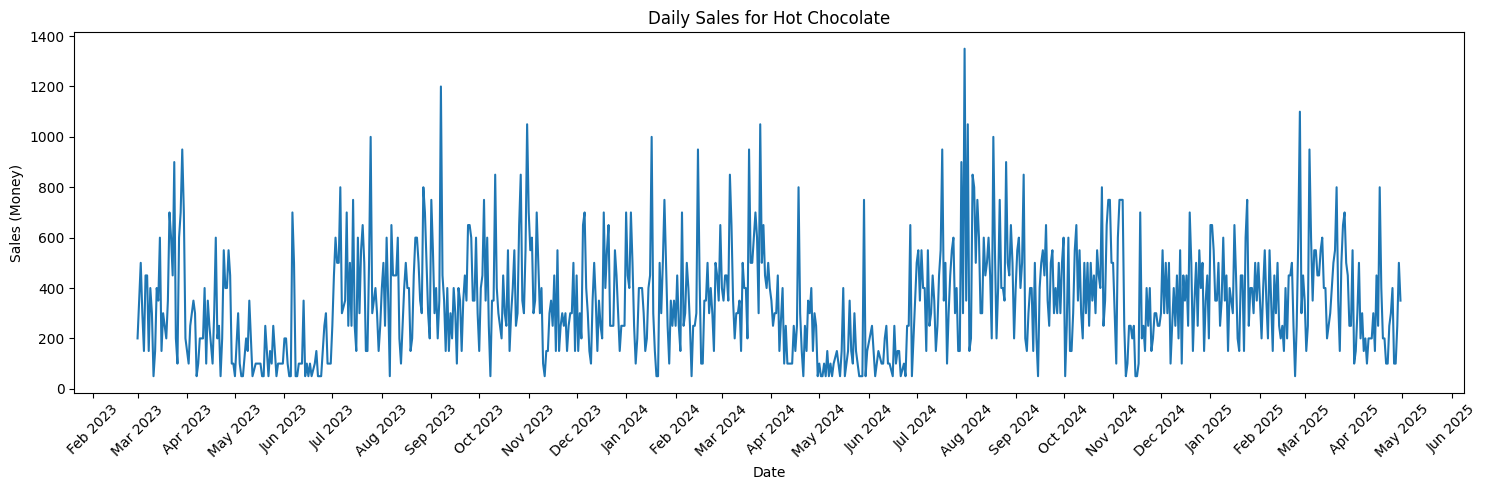

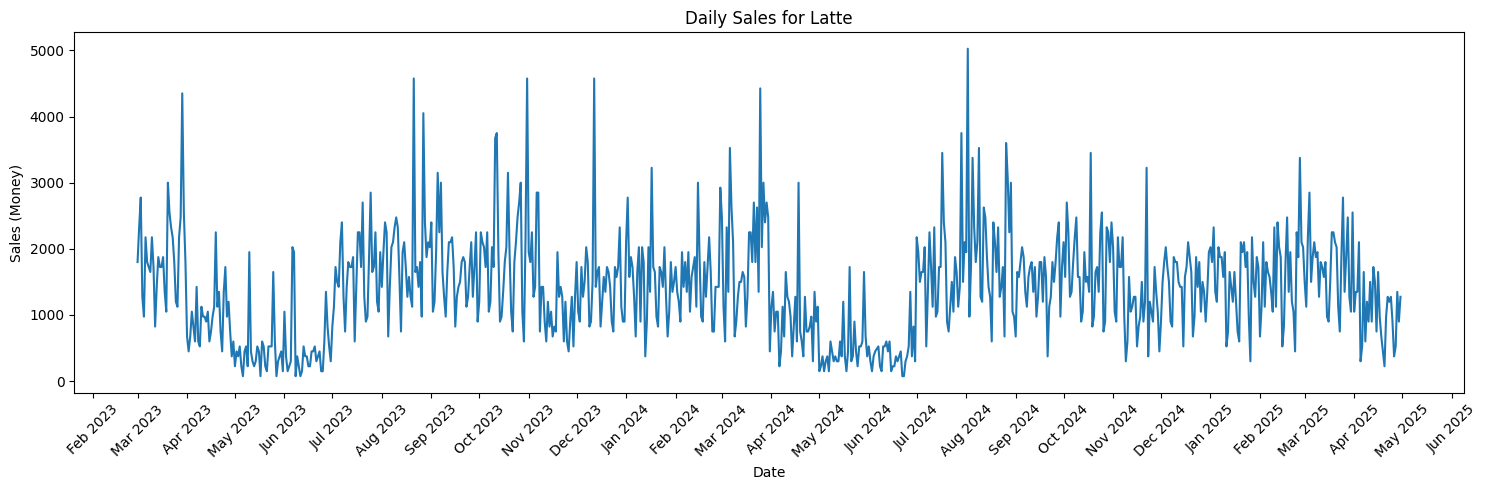

In [23]:
for coffee_name in coffee_items:
    coffee_sales = daily_sales_by_item[daily_sales_by_item['coffee_name'] == coffee_name].copy()
    coffee_sales.set_index('date', inplace=True)

    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['money'])
    plt.title(f'Daily Sales for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [30]:
def create_sales_features(df):
    df = df.copy()
    df = df.rename(columns={'money':'total_sales'})
    df.set_index('date', inplace=True)
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year
    df.sort_index(inplace=True)
    df['lag_7'] = df['total_sales'].shift(7)
    df['lag_14'] = df['total_sales'].shift(14)
    df['rolling_mean_7'] = df['total_sales'].shift(1).rolling(window=7).mean()
    df.reset_index(inplace=True)
    return df

In [31]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'total_sales'
split_date = pd.to_datetime('2025-03-01')

def split_train_test(data):
    train_data = data[data['date'] < split_date]
    test_data = data[data['date'] >= split_date]
    return train_data, test_data


=== Americano ===
Random Forest MAE: 298.13
XGBoost MAE: 271.91
ยอดขายรวมใน Test Set: 55445.00 บาท


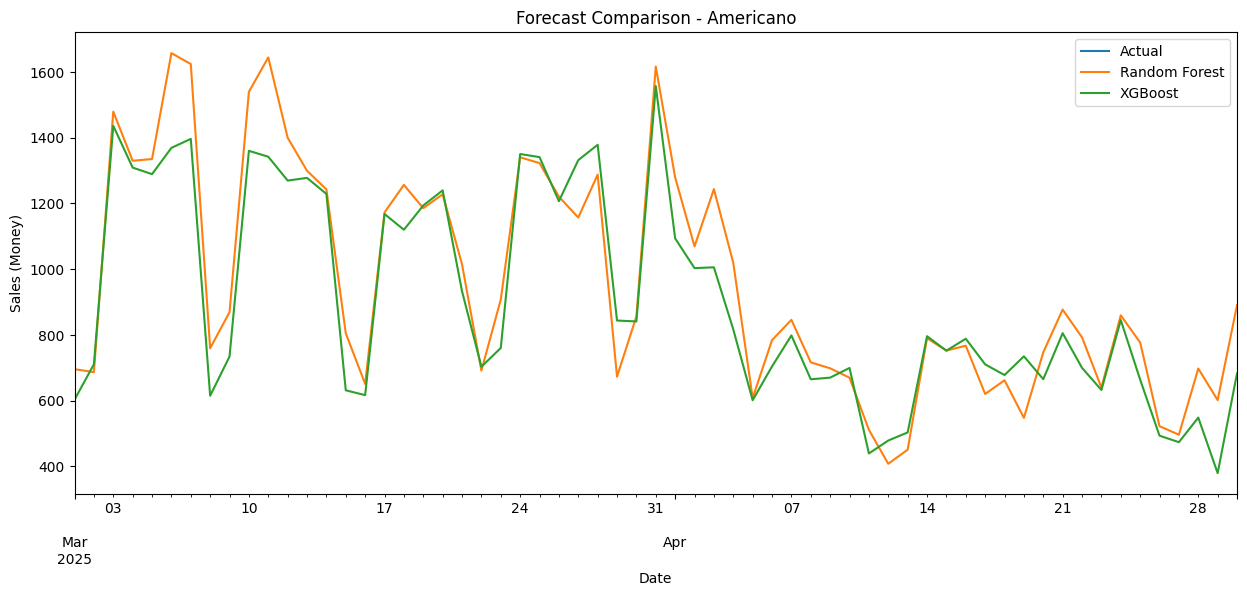


=== Americano with Milk ===
Random Forest MAE: 388.86
XGBoost MAE: 352.62
ยอดขายรวมใน Test Set: 86940.00 บาท


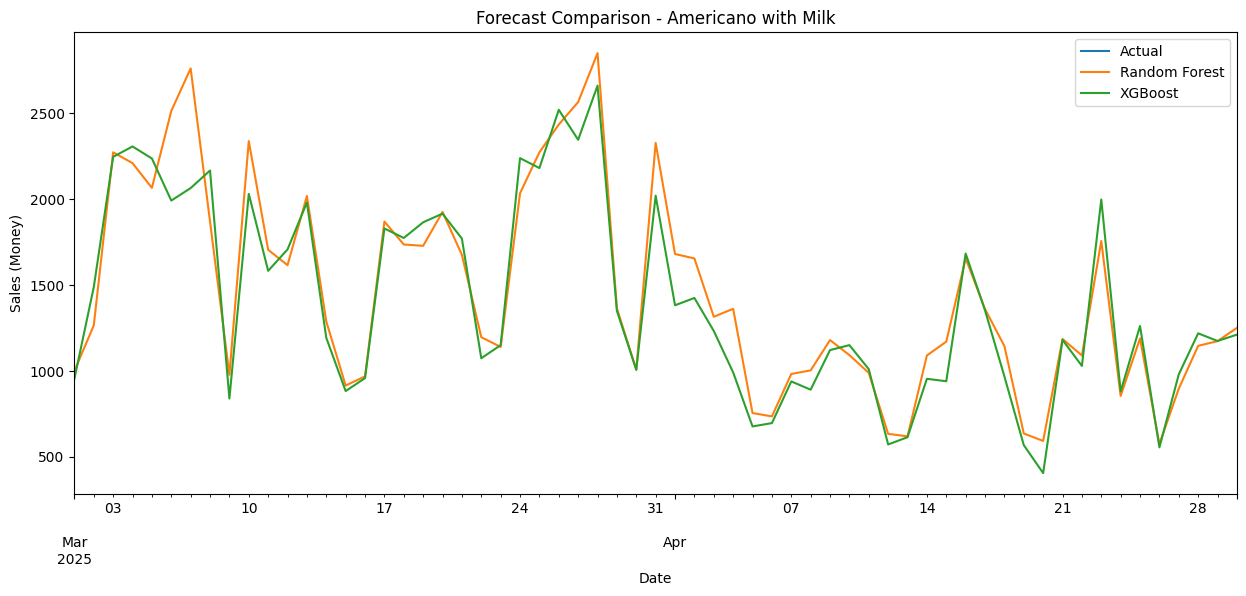


=== Cappuccino ===
Random Forest MAE: 301.97
XGBoost MAE: 295.78
ยอดขายรวมใน Test Set: 56250.00 บาท


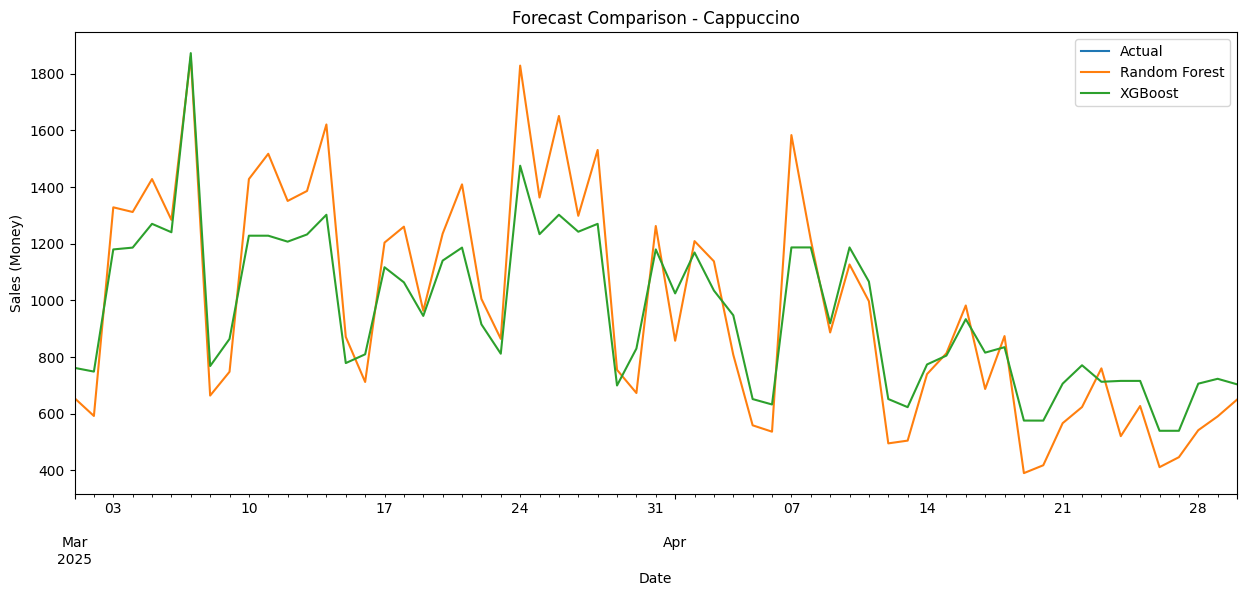


=== Cocoa ===
Random Forest MAE: 115.11
XGBoost MAE: 115.68
ยอดขายรวมใน Test Set: 19300.00 บาท


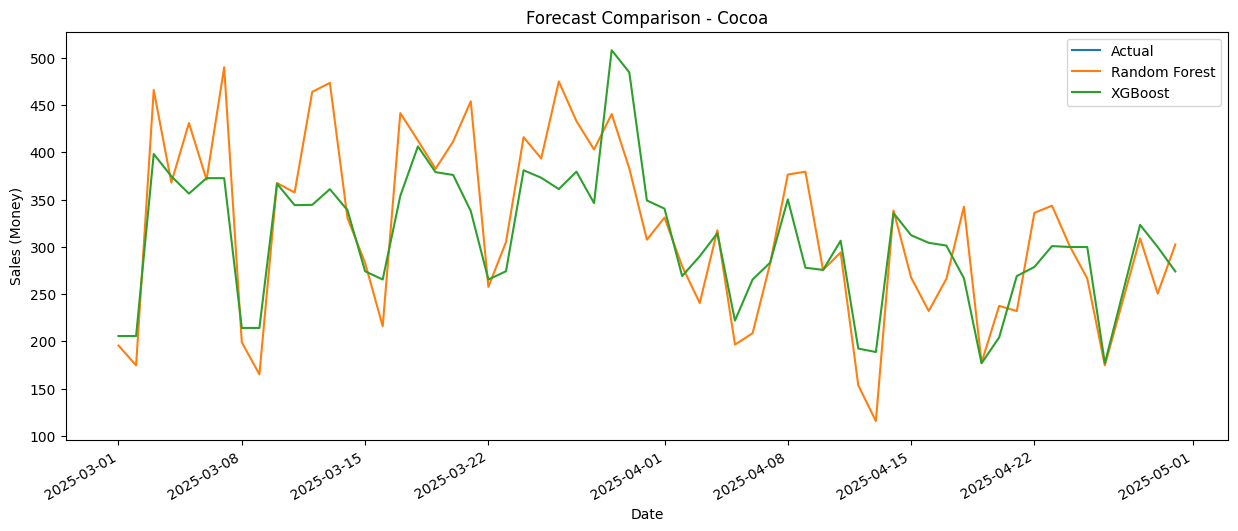


=== Cortado ===
Random Forest MAE: 201.71
XGBoost MAE: 207.16
ยอดขายรวมใน Test Set: 28840.00 บาท


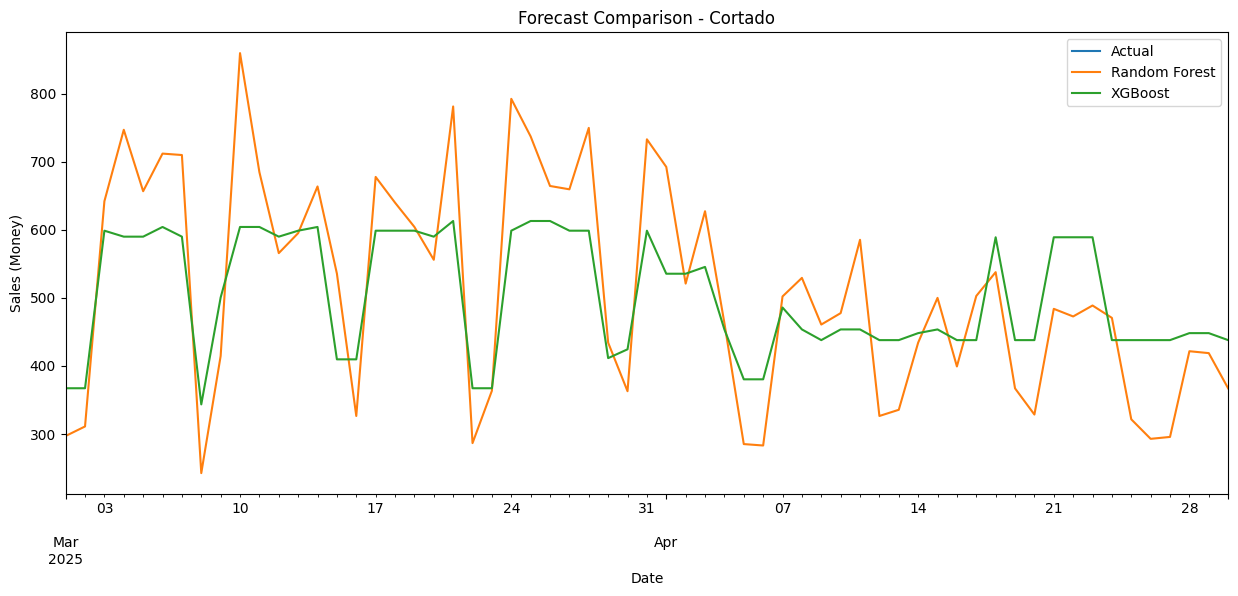


=== Espresso ===
Random Forest MAE: 98.42
XGBoost MAE: 93.82
ยอดขายรวมใน Test Set: 12155.00 บาท


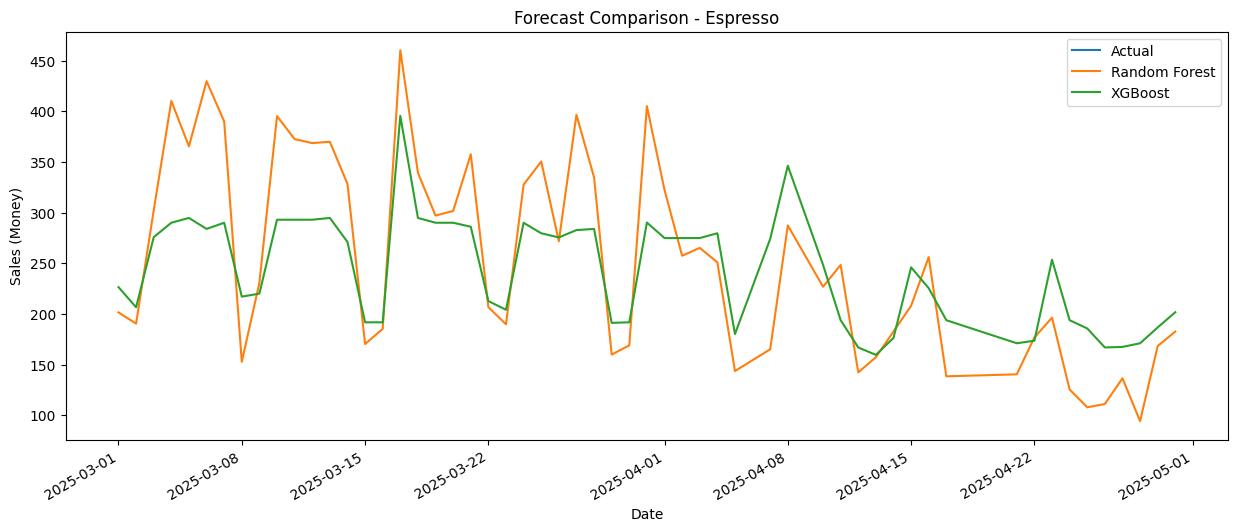


=== Hot Chocolate ===
Random Forest MAE: 143.05
XGBoost MAE: 128.22
ยอดขายรวมใน Test Set: 21750.00 บาท


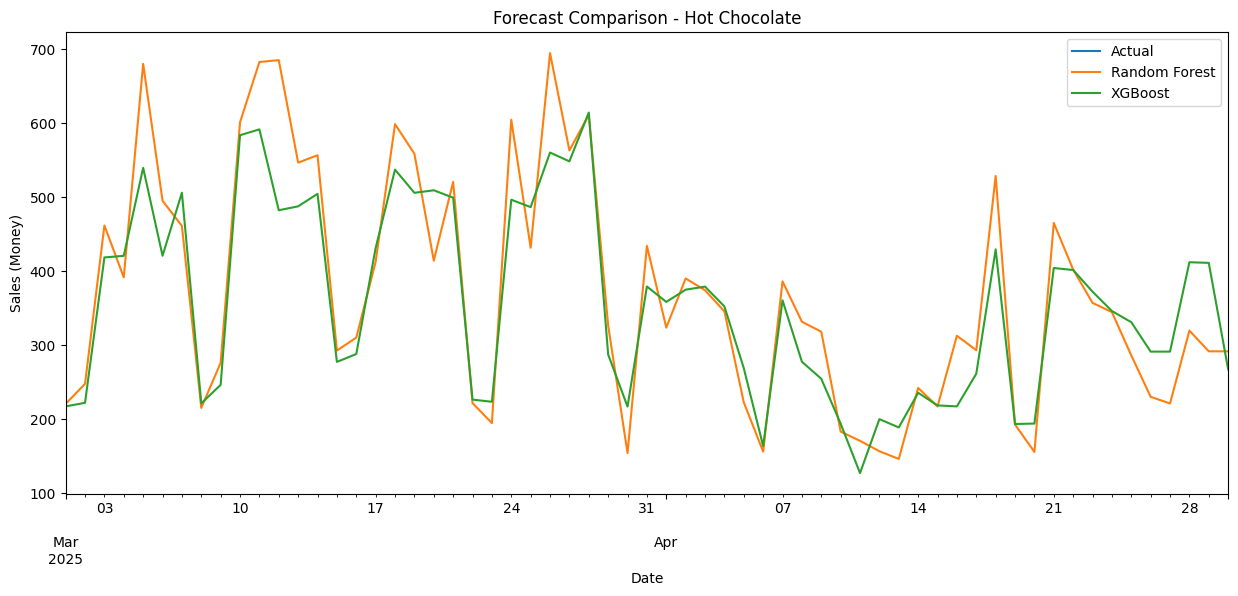


=== Latte ===
Random Forest MAE: 369.20
XGBoost MAE: 374.79
ยอดขายรวมใน Test Set: 85650.00 บาท


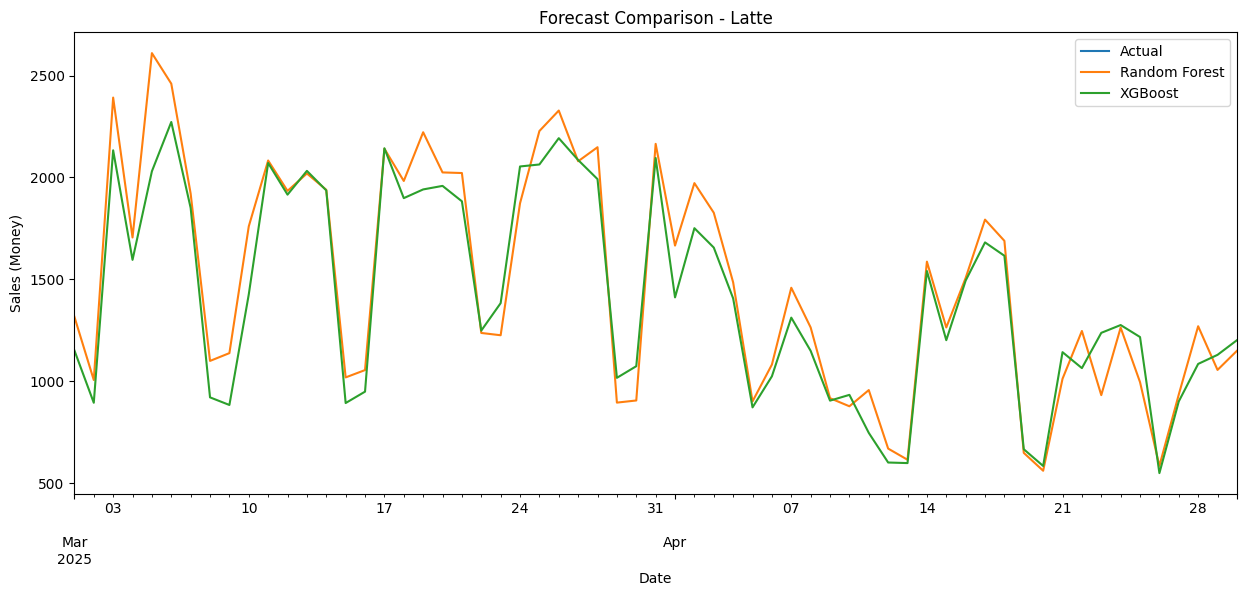

In [32]:
results_all_models = {}

for coffee in coffee_items:
    print(f"\n=== {coffee} ===")
    coffee_df = daily_sales_by_item[daily_sales_by_item['coffee_name'] == coffee]
    coffee_df = create_sales_features(coffee_df)
    coffee_df.dropna(inplace=True)

    train_data, test_data = split_train_test(coffee_df)
    X_train, y_train = train_data[FEATURES], train_data[TARGET]
    X_test, y_test = test_data[FEATURES], test_data[TARGET]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train) #print

    xgb_model = xgb.XGBRegressor(n_estimators=100,
                                 learning_rate=0.05,
                                 early_stopping_rounds=10,
                                 random_state=42)
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False) #print

    rf_pred = rf_model.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)

    rf_mae = mean_absolute_error(y_test, rf_pred)
    xgb_mae = mean_absolute_error(y_test, xgb_pred)

    print(f"Random Forest MAE: {rf_mae:.2f}")
    print(f"XGBoost MAE: {xgb_mae:.2f}")
    print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} บาท")

    results = pd.DataFrame({'Actual': y_test,
                            'Random Forest': rf_pred,
                            'XGBoost': xgb_pred},
                            index=test_data['date'])

    results_all_models[coffee] = {'rf': rf_model, 'xgb': xgb_model, 'results': results}

    results.plot(figsize=(15, 6), title=f'Forecast Comparison - {coffee}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')
    plt.show() #print


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/n74nnqby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/w84znhjw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46185', 'data', 'file=/tmp/tmp4yarbpd1/n74nnqby.json', 'init=/tmp/tmp4yarbpd1/w84znhjw.json', 'output', 'file=/tmp/tmp4yarbpd1/prophet_model3fbz9xul/prophet_model-20250921162355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:23:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:23:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



=== Prophet for Americano ===
Prophet MAE: 293.04
ยอดขายรวมใน Test Set (Prophet): 55445.00 บาท


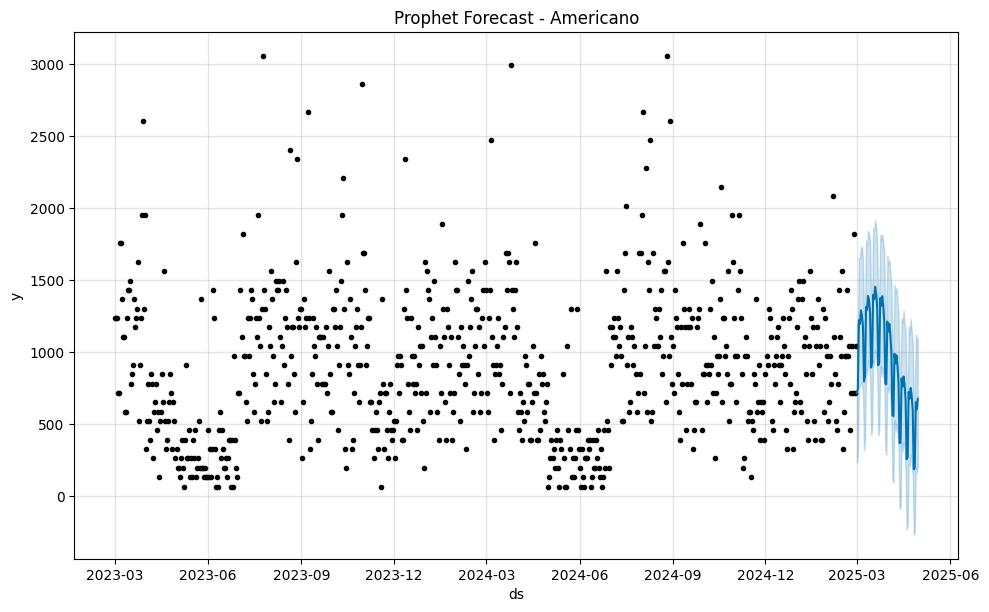

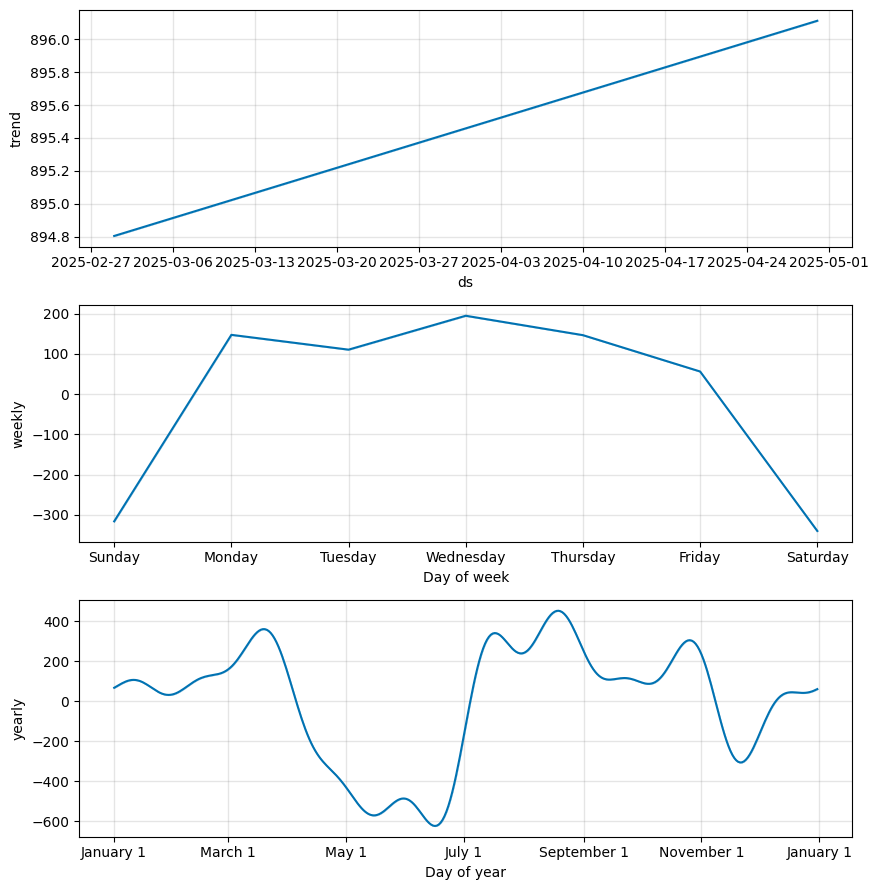

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/fs8psixp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/n7il6j7r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62951', 'data', 'file=/tmp/tmp4yarbpd1/fs8psixp.json', 'init=/tmp/tmp4yarbpd1/n7il6j7r.json', 'output', 'file=/tmp/tmp4yarbpd1/prophet_modelh772tmp4/prophet_model-20250921162356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:23:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:23:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



=== Prophet for Americano with Milk ===
Prophet MAE: 411.74
ยอดขายรวมใน Test Set (Prophet): 86940.00 บาท


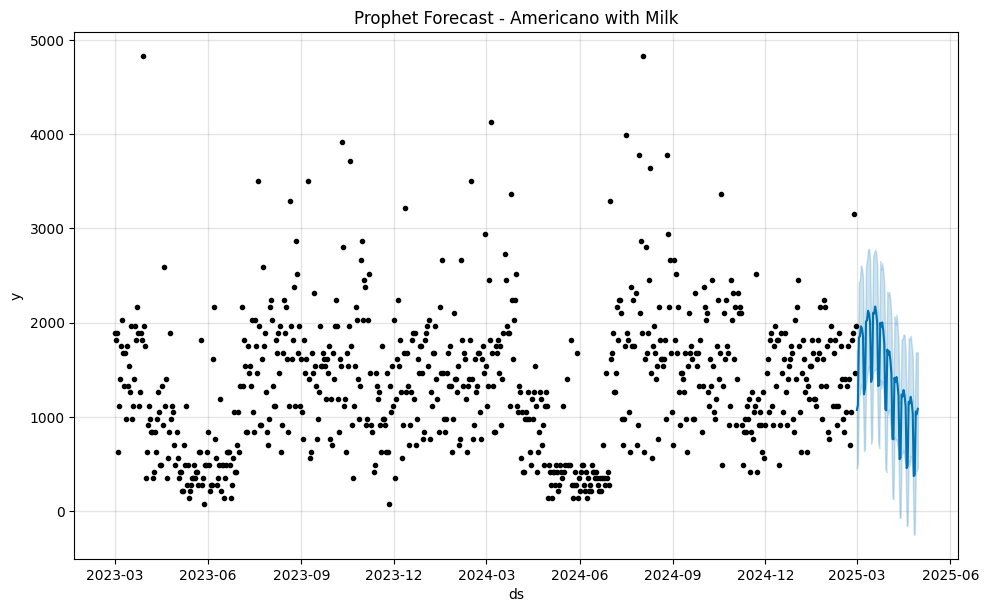

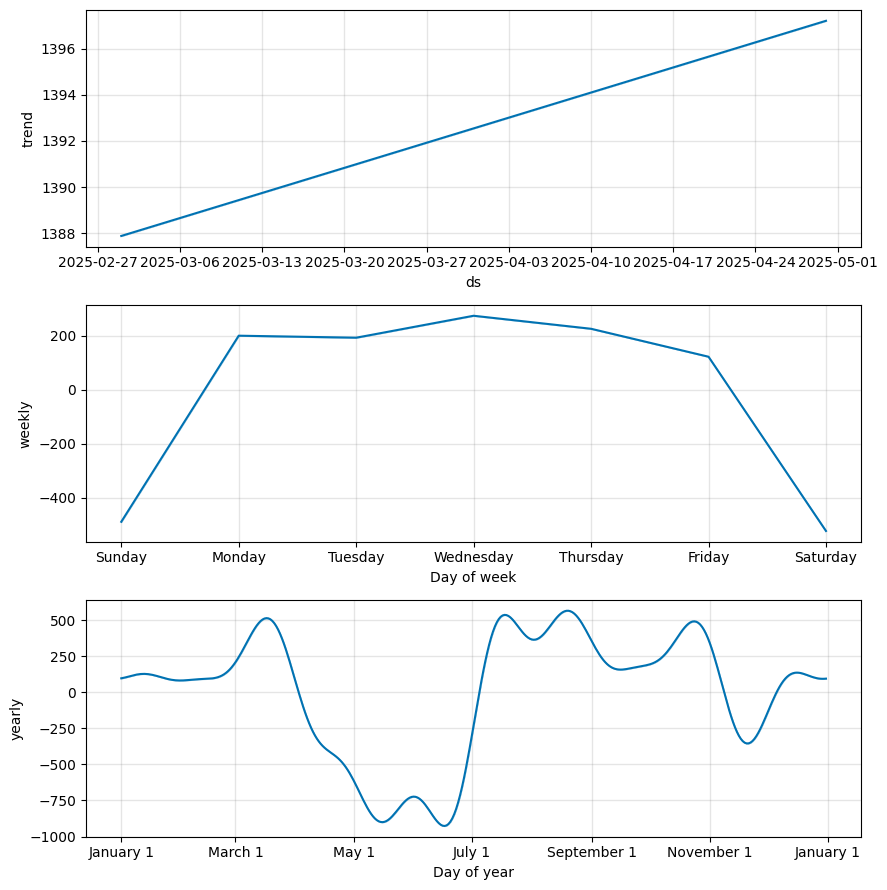

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/f8jxr985.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/0qxe2neu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51961', 'data', 'file=/tmp/tmp4yarbpd1/f8jxr985.json', 'init=/tmp/tmp4yarbpd1/0qxe2neu.json', 'output', 'file=/tmp/tmp4yarbpd1/prophet_model1m69wdb8/prophet_model-20250921162357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:23:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Prophet for Cappuccino ===


16:23:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 231.71
ยอดขายรวมใน Test Set (Prophet): 56250.00 บาท


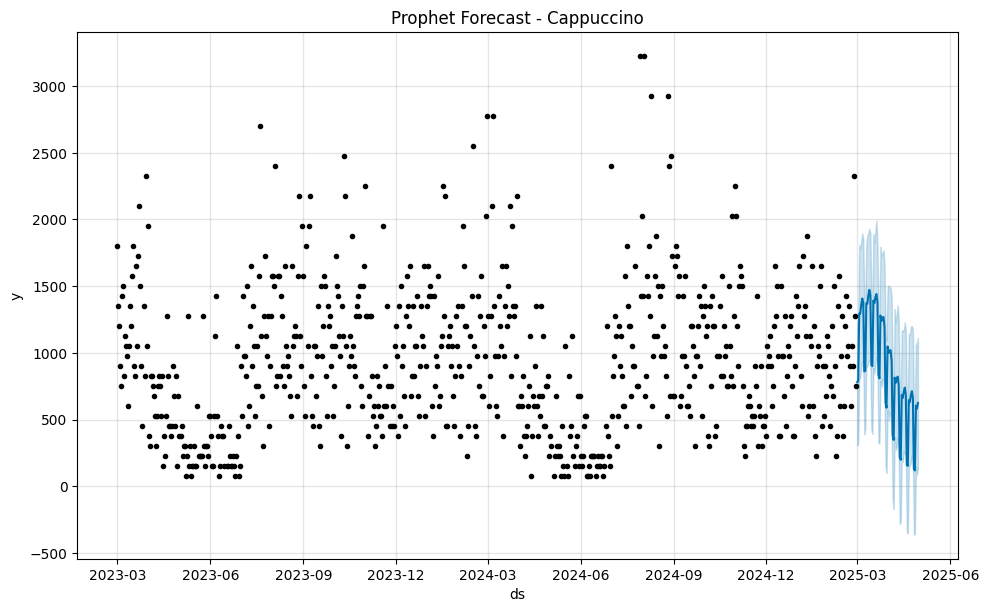

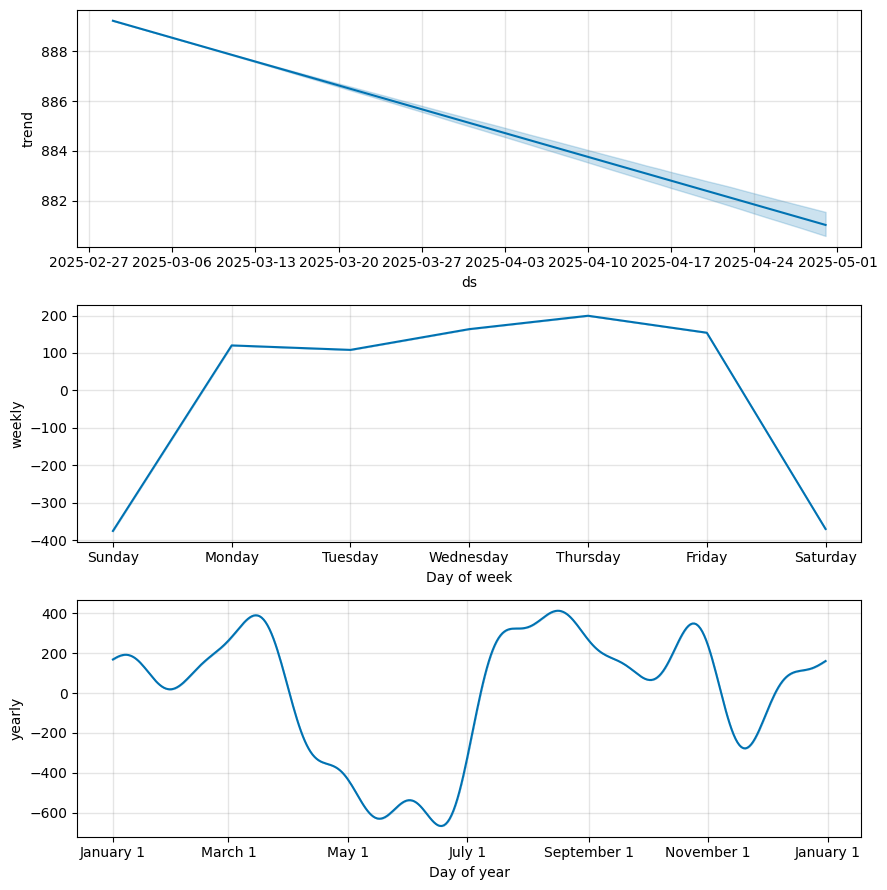

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/jfnvqzer.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/hezgs3s8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63701', 'data', 'file=/tmp/tmp4yarbpd1/jfnvqzer.json', 'init=/tmp/tmp4yarbpd1/hezgs3s8.json', 'output', 'file=/tmp/tmp4yarbpd1/prophet_modelcisx974t/prophet_model-20250921162358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:23:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:23:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



=== Prophet for Cocoa ===
Prophet MAE: 110.64
ยอดขายรวมใน Test Set (Prophet): 19300.00 บาท


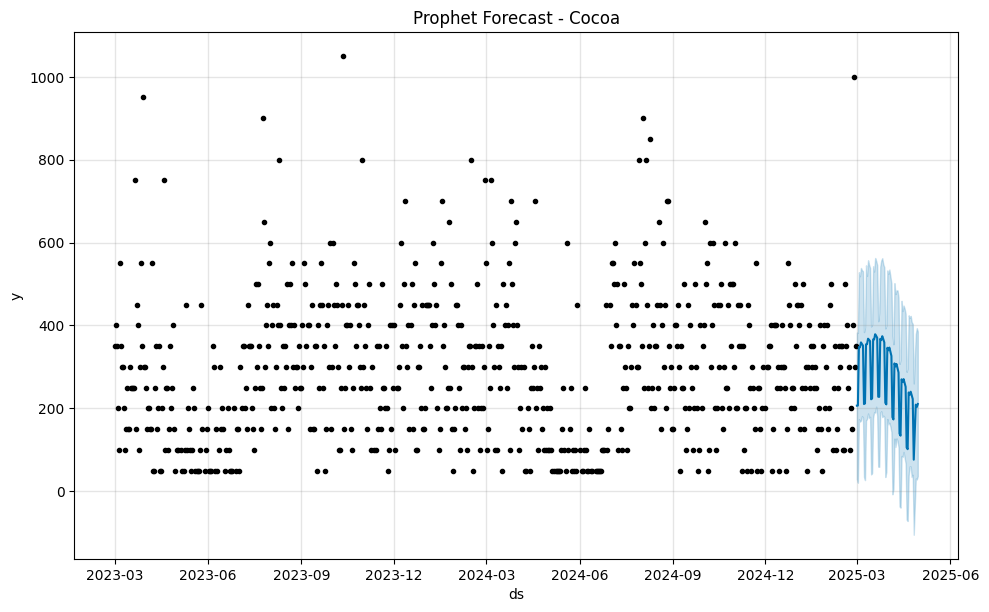

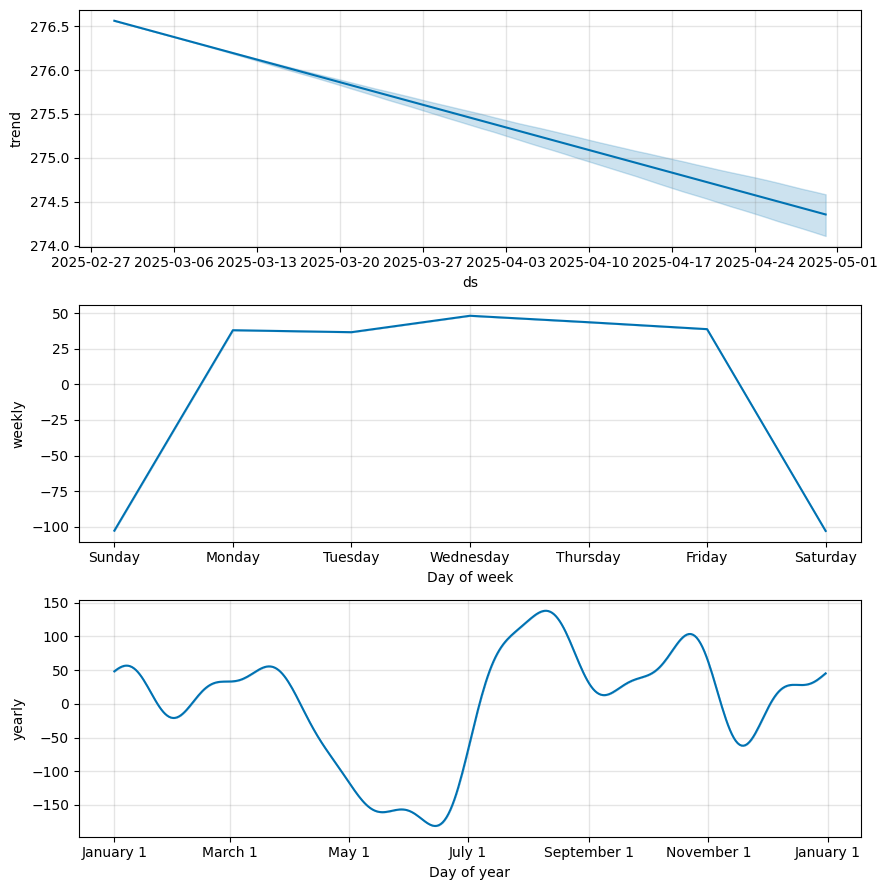

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



=== Prophet for Cortado ===


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/it7ve4iw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/gxrcn5an.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35105', 'data', 'file=/tmp/tmp4yarbpd1/it7ve4iw.json', 'init=/tmp/tmp4yarbpd1/gxrcn5an.json', 'output', 'file=/tmp/tmp4yarbpd1/prophet_modeljk1d4m2q/prophet_model-20250921162359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:23:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:23:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 180.44
ยอดขายรวมใน Test Set (Prophet): 28840.00 บาท


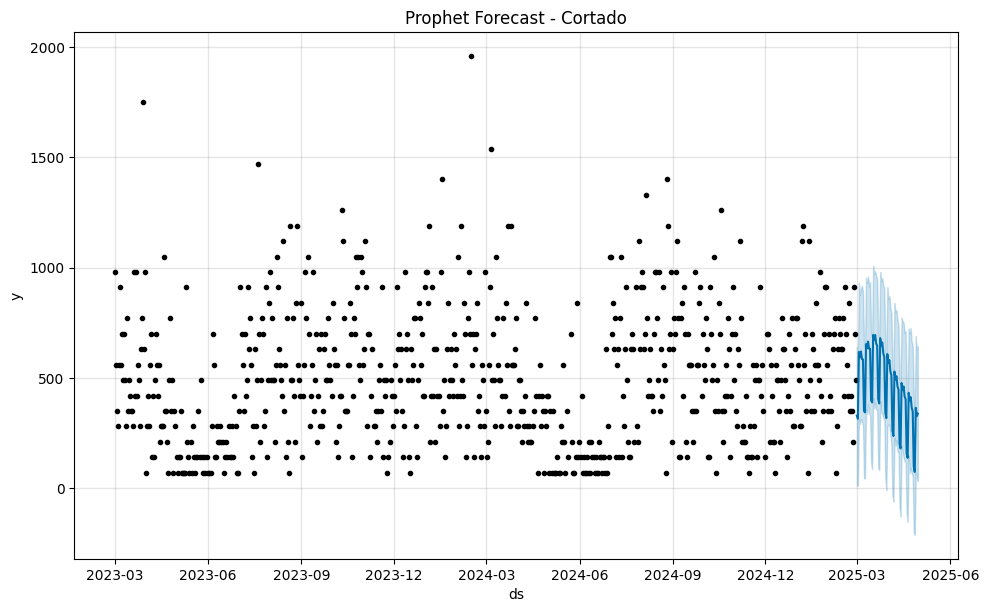

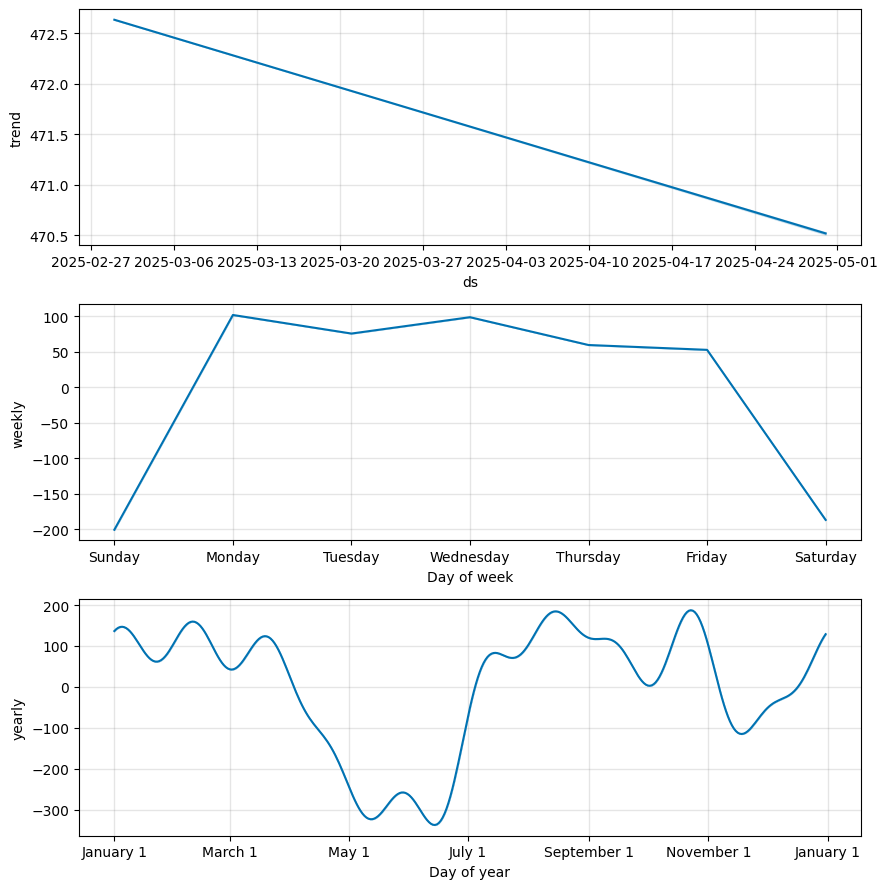

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/tzw44m_3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/gdyspd28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72303', 'data', 'file=/tmp/tmp4yarbpd1/tzw44m_3.json', 'init=/tmp/tmp4yarbpd1/gdyspd28.json', 'output', 'file=/tmp/tmp4yarbpd1/prophet_modeljh6n8n3s/prophet_model-20250921162400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:24:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:24:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



=== Prophet for Espresso ===
Prophet MAE: 93.27
ยอดขายรวมใน Test Set (Prophet): 12155.00 บาท


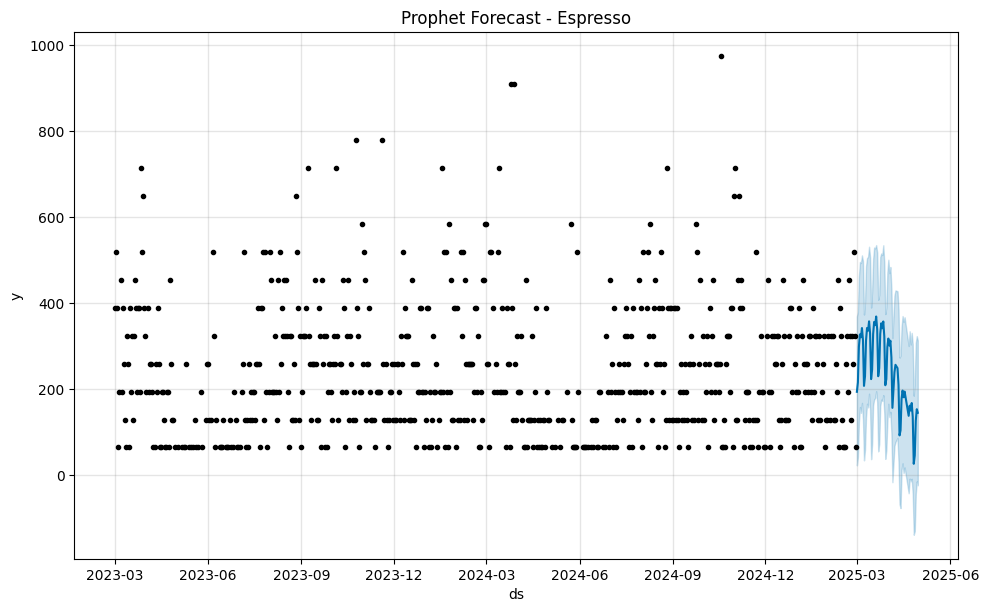

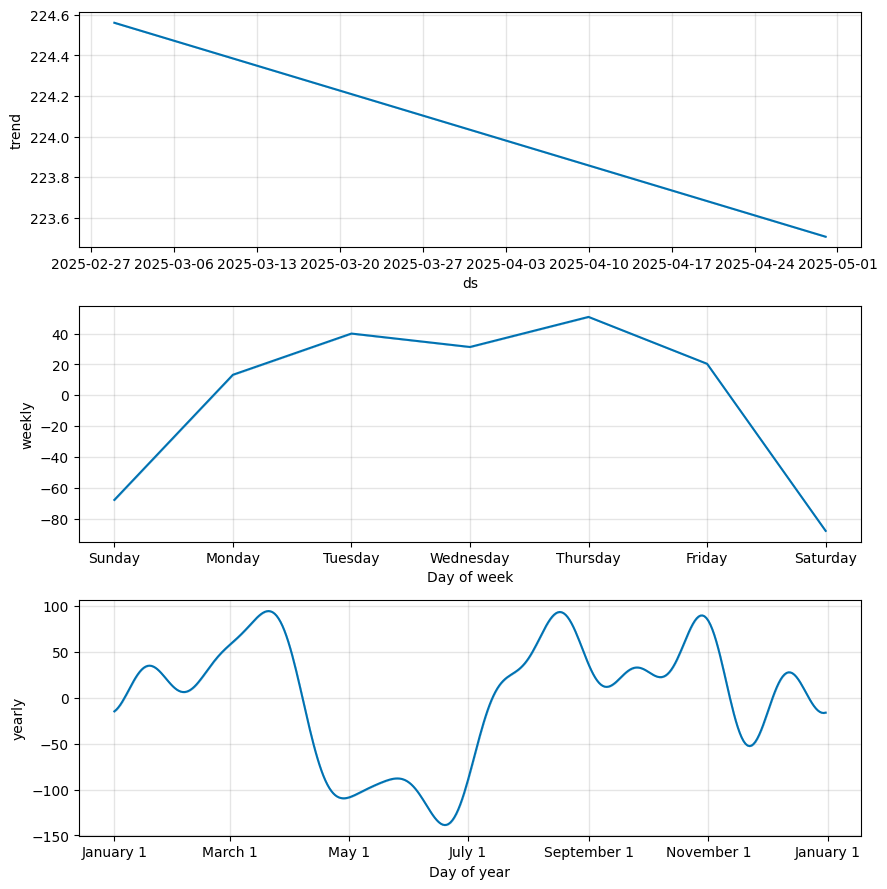

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/qf5xgmhb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/opg7d8s6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97810', 'data', 'file=/tmp/tmp4yarbpd1/qf5xgmhb.json', 'init=/tmp/tmp4yarbpd1/opg7d8s6.json', 'output', 'file=/tmp/tmp4yarbpd1/prophet_model_evk985r/prophet_model-20250921162401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:24:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



=== Prophet for Hot Chocolate ===
Prophet MAE: 135.40
ยอดขายรวมใน Test Set (Prophet): 21750.00 บาท


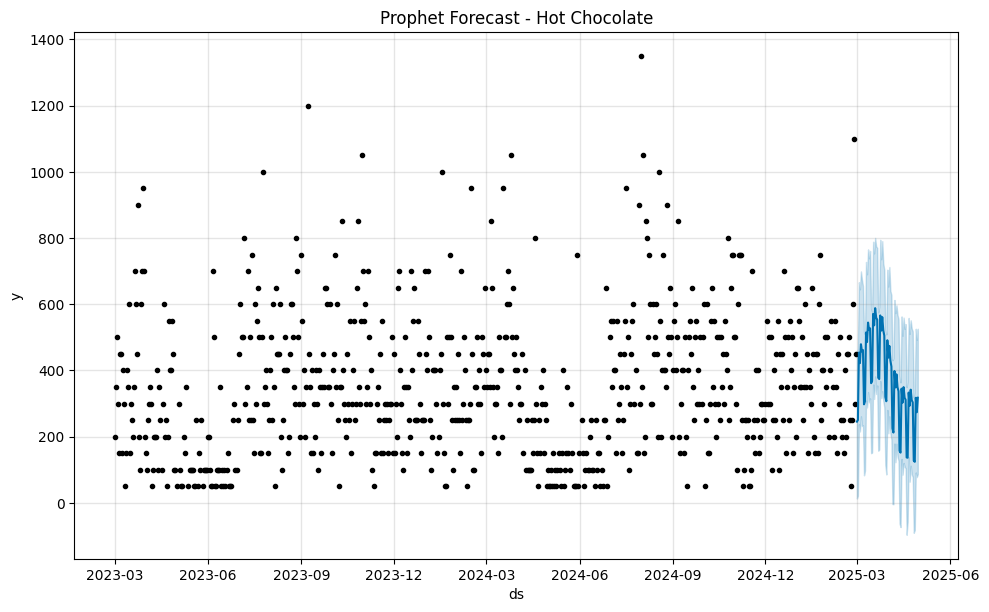

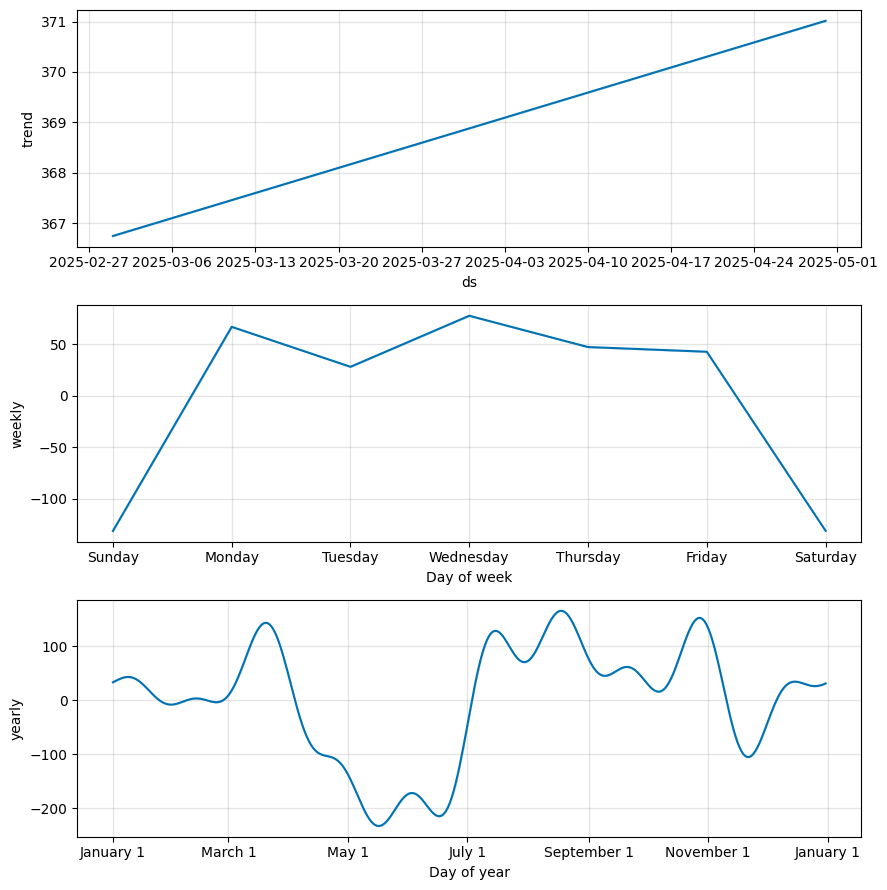

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/ri34io1g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4yarbpd1/mgy1ke88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11425', 'data', 'file=/tmp/tmp4yarbpd1/ri34io1g.json', 'init=/tmp/tmp4yarbpd1/mgy1ke88.json', 'output', 'file=/tmp/tmp4yarbpd1/prophet_modelm68_0o1_/prophet_model-20250921162401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:24:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



=== Prophet for Latte ===
Prophet MAE: 364.96
ยอดขายรวมใน Test Set (Prophet): 85650.00 บาท


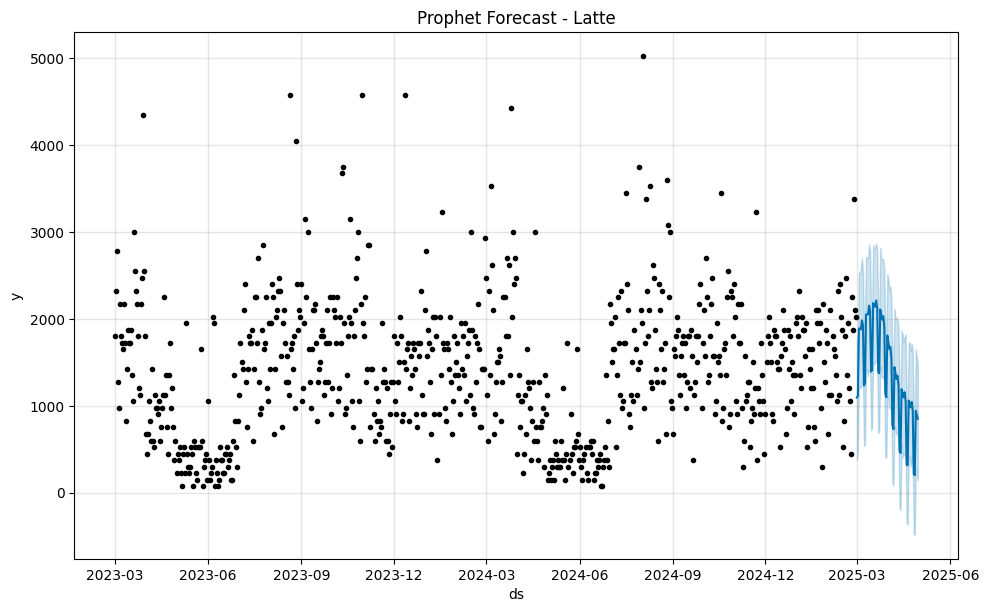

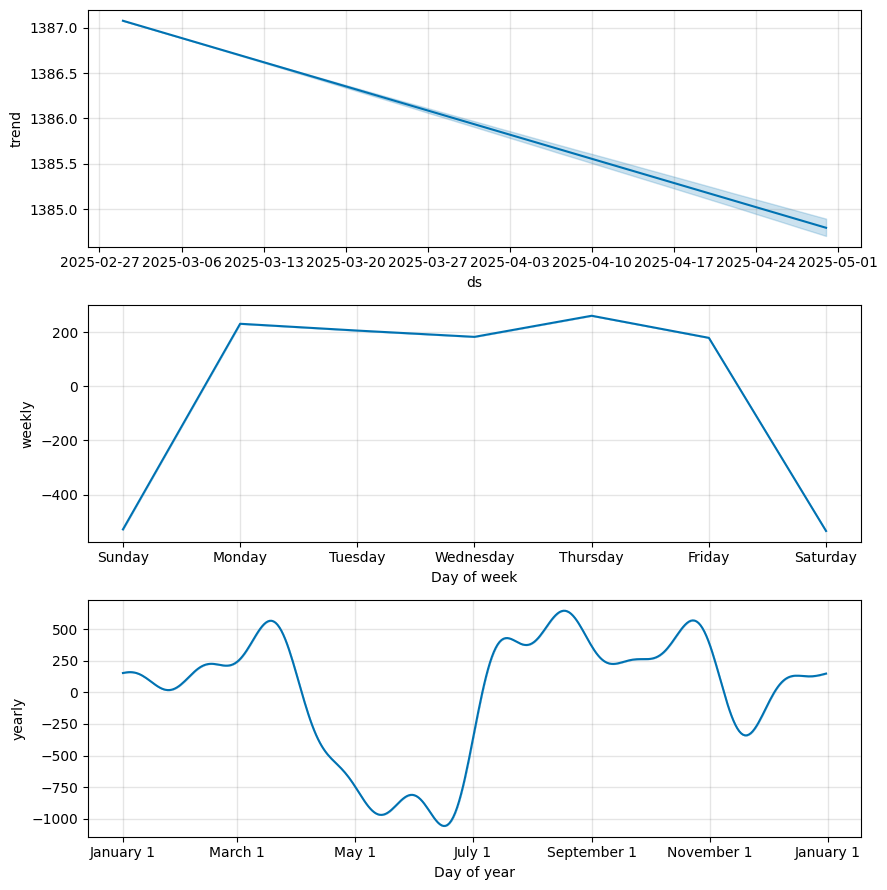

In [33]:
!pip install prophet
from prophet import Prophet

prophet_results_all = {}

for coffee in coffee_items:
    print(f"\n=== Prophet for {coffee} ===")
    coffee_df = daily_sales_by_item[daily_sales_by_item['coffee_name'] == coffee]
    coffee_df = coffee_df.rename(columns={'money':'total_sales'})
    train_data, test_data = split_train_test(coffee_df)

    prophet_train = train_data[['date','total_sales']].rename(columns={'date':'ds','total_sales':'y'})
    prophet_test = test_data[['date','total_sales']].rename(columns={'date':'ds','total_sales':'y'})

    model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    model.fit(prophet_train) #print

    forecast = model.predict(prophet_test)
    merged = forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds')[['y']])
    merged.dropna(inplace=True)
    prophet_mae = mean_absolute_error(merged['y'], merged['yhat'])

    print(f"Prophet MAE: {prophet_mae:.2f}")
    print(f"ยอดขายรวมใน Test Set (Prophet): {merged['y'].sum():.2f} บาท")

    fig1 = model.plot(forecast)
    plt.title(f'Prophet Forecast - {coffee}')
    plt.show() #print

    fig2 = model.plot_components(forecast)
    plt.show() #print

    prophet_results_all[coffee] = merged


In [34]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-m04ewvoh
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-m04ewvoh
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done



=== Chronos Forecast: Americano ===


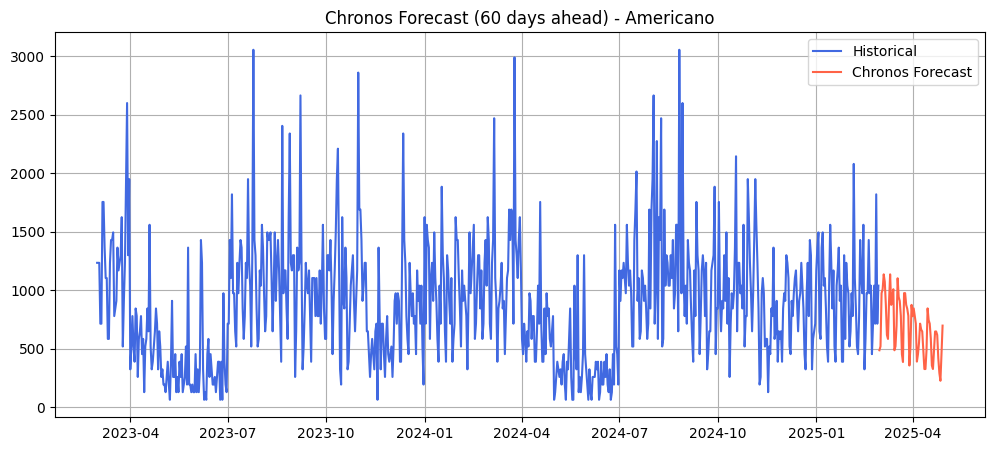


=== Chronos Forecast: Americano with Milk ===


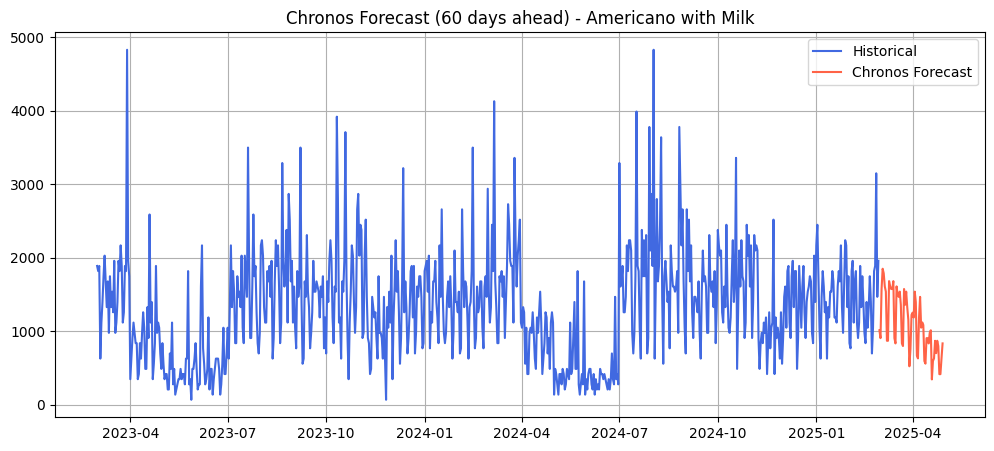


=== Chronos Forecast: Cappuccino ===


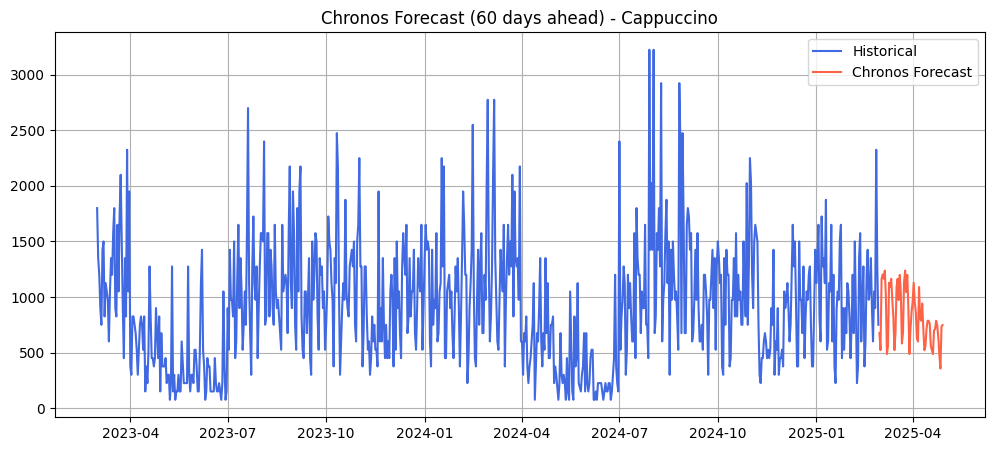


=== Chronos Forecast: Cocoa ===


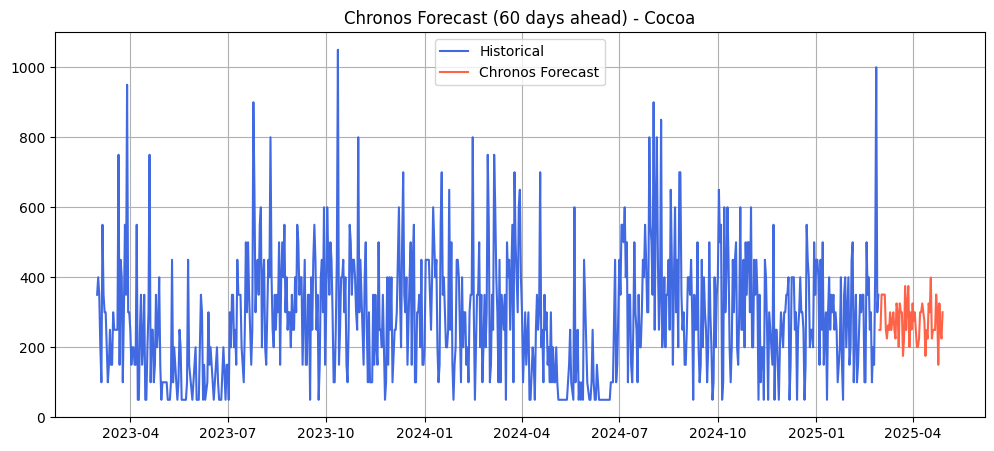


=== Chronos Forecast: Cortado ===


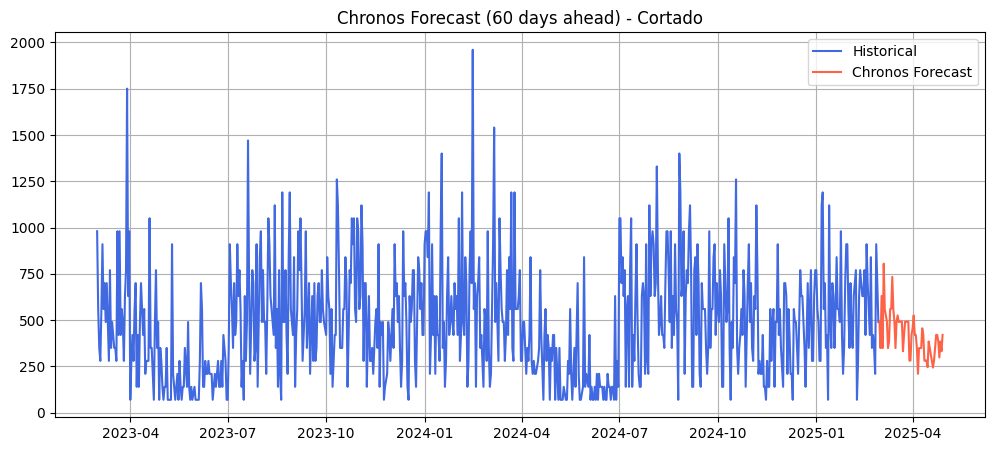


=== Chronos Forecast: Espresso ===


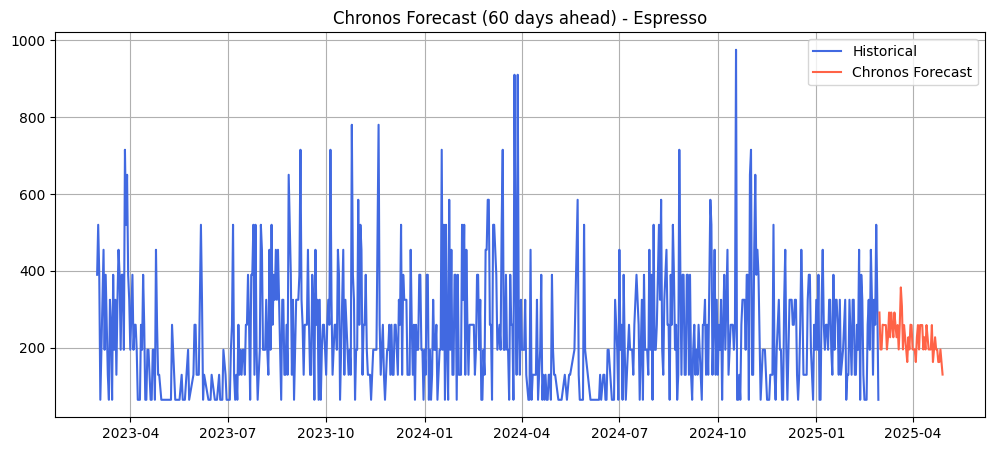


=== Chronos Forecast: Hot Chocolate ===


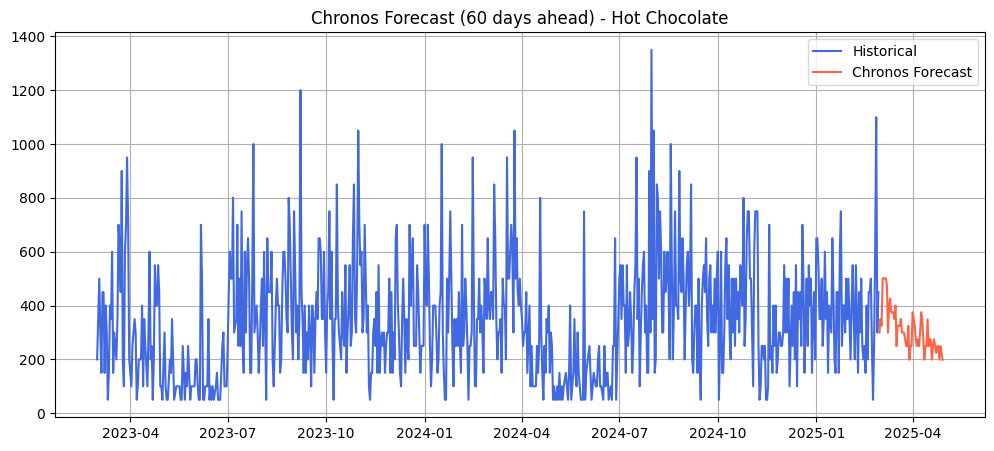


=== Chronos Forecast: Latte ===


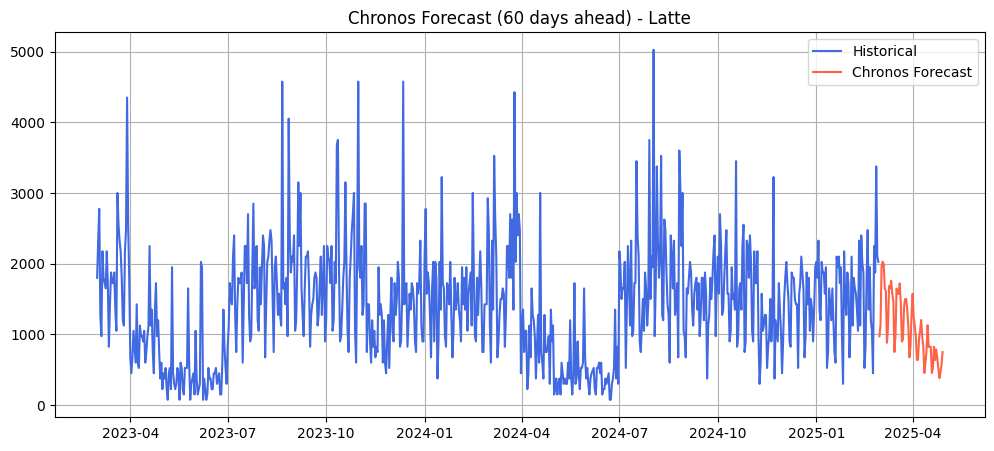

In [35]:
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

chronos_results = {}

for coffee in coffee_items:
    print(f"\n=== Chronos Forecast: {coffee} ===")
    item_sales = daily_sales_by_item[daily_sales_by_item['coffee_name'] == coffee].copy()
    historical = item_sales[item_sales['date'] < split_date]

    # แปลงข้อมูลเป็น tensor
    context = torch.tensor(historical['money'].values, dtype=torch.float32)
    forecast = pipeline.predict(context, prediction_length=60)
    median_forecast = np.median(forecast[0].numpy(), axis=0)

    chronos_results[coffee] = {"history": historical, "forecast": median_forecast}

    # เตรียมวันที่
    last_date = historical['date'].iloc[-1]
    forecast_dates = pd.date_range(start=last_date+pd.Timedelta(days=1), periods=60)

    # สร้างกราฟใหม่ทุกครั้ง
    plt.figure(figsize=(12,5))
    plt.plot(historical['date'], historical['money'], label="Historical", color="royalblue")
    plt.plot(forecast_dates, median_forecast, label="Chronos Forecast", color="tomato")
    plt.title(f"Chronos Forecast (60 days ahead) - {coffee}")
    plt.legend()
    plt.grid(True)
    plt.show()  #print


In [36]:
forecast_tables = []
for coffee, result in chronos_results.items():
    last_date = result["history"]['date'].iloc[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
    temp_df = pd.DataFrame({
        "date": forecast_dates,
        "coffee_name": coffee,
        "forecast": result["forecast"]
    })
    forecast_tables.append(temp_df)

all_forecasts_df = pd.concat(forecast_tables, ignore_index=True)

# แสดงทั้งหมด
display(all_forecasts_df)  #print


date coffee_name     forecast
0   2025-03-01   Americano   488.042633
1   2025-03-02   Americano   521.470215
2   2025-03-03   Americano   976.085266
3   2025-03-04   Americano  1009.512817
4   2025-03-05   Americano  1136.537598
..         ...         ...          ...
475 2025-04-25       Latte   528.052551
476 2025-04-26       Latte   380.197845
477 2025-04-27       Latte   454.125214
478 2025-04-28       Latte   565.016235
479 2025-04-29       Latte   749.834656

[480 rows x 3 columns]